In [107]:
from dataclasses import replace
import random
from collections import Counter

from replenishment import (
    build_point_forecast_article_configs_from_standard_rows,
    build_replenishment_decisions_from_simulations,
    compute_backtest_rmse_by_article,
    generate_standard_simulation_rows,
    optimize_aggregation_and_service_level_factors,
    optimize_service_level_factors,
    plot_replenishment_decisions,
    replenishment_decision_rows_to_dataframe,
    simulate_replenishment_for_articles,
    simulate_replenishment_with_aggregation,
    split_standard_simulation_rows,
    standard_simulation_rows_to_dataframe,
)

# Mean Forecast: Service-Level Probability
This notebook treats `sigma` as a probability (cycle service level) and compares:  
1) optimizing sigma only,  
2) optimizing sigma + aggregation window.


## 1) Generate Sample Data
We generate synthetic history + forecast rows. Forecast periods are given simulated actuals so we can compare forecast vs. actuals in evaluation.


In [108]:

history_mean = 20.0
history_std = 8.0
forecast_mean = 18.0
forecast_std = 6.0

rows = generate_standard_simulation_rows(
    n_unique_ids=200,
    periods=120,
    history_mean=history_mean,
    history_std=history_std,
    forecast_mean=forecast_mean,
    forecast_std=forecast_std,
    forecast_start_period=60,
    lead_time=3,    
    initial_on_hand=25,
    current_stock=25,
    holding_cost_per_unit=1,
    stockout_cost_per_unit=5,
    order_cost_per_order=10,
)

backtest_rows, evaluation_rows = split_standard_simulation_rows(rows)

# Add simulated actuals for the forecast/evaluation period.
rng = random.Random(7)
def _sample_int(mean: float, std: float) -> int:
    return max(0, int(round(rng.gauss(mean, std))))

evaluation_rows_actuals = []
for row in evaluation_rows:
    actual = _sample_int(history_mean, history_std)
    evaluation_rows_actuals.append(replace(row, actuals=actual, demand=actual))

evaluation_rows = evaluation_rows_actuals

rows_df = standard_simulation_rows_to_dataframe(
    backtest_rows + evaluation_rows, library="pandas"
)
print(f"backtest rows: {len(backtest_rows)}, forecast rows: {len(evaluation_rows)}")
if not evaluation_rows:
    raise ValueError("No forecast rows found. Set forecast_start_period to create forecast rows.")

candidate_service_levels = [.1, .12, .14, .16, .18, .2, .22, .24, .26, .28, .3, .32, .34, .36, .38, .4, .42,  .5, 
                       .6, .62, .64, .66, .68, 0.7, .72, .74, .76, 
                       .78, 0.8, .82, .84, .86, .88, .90, .92, .94, .96, .99
                       ]
candidate_windows = [3, 6, 9]


backtest rows: 12000, forecast rows: 12000


## 2) Optimize Sigma Only (Service-Level Probability)


In [109]:
backtest_rmse = compute_backtest_rmse_by_article(backtest_rows)

point_configs = build_point_forecast_article_configs_from_standard_rows(
    backtest_rows,
    service_level_factor=candidate_service_levels[0],
    service_level_mode="service_level",
    fixed_rmse=backtest_rmse,
)

optimized = optimize_service_level_factors(
    point_configs,
    candidate_factors=candidate_service_levels,
    service_level_mode="service_level",
)

best_factors = {
    unique_id: result.service_level_factor
    for unique_id, result in optimized.items()
}

backtest_actuals = {}
for row in backtest_rows:
    backtest_actuals.setdefault(row.unique_id, []).append(row)
for unique_id, series in backtest_actuals.items():
    series.sort(key=lambda r: r.ds)
    backtest_actuals[unique_id] = [int(r.actuals) for r in series]

eval_configs = build_point_forecast_article_configs_from_standard_rows(
    evaluation_rows,
    service_level_factor=best_factors,
    service_level_mode="service_level",
    fixed_rmse=backtest_rmse,
    actuals_override=backtest_actuals,
)
eval_simulations = simulate_replenishment_for_articles(eval_configs)
eval_decisions = build_replenishment_decisions_from_simulations(
    evaluation_rows,
    eval_simulations,
    sigma=best_factors,
    fixed_rmse=backtest_rmse,
    service_level_mode="service_level",
)


In [110]:
sigma_decisions_df = replenishment_decision_rows_to_dataframe(eval_decisions)
sigma_decisions_df.head()


,unique_id,ds,quantity,demand,forecast_quantity,forecast_quantity_lead_time,reorder_point,order_up_to,incoming_stock,starting_stock,...,safety_stock,starting_on_hand,ending_on_hand,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,percentile_target
0,A,2028-12-05,50,18,19,50,87.413721,106.413721,0,25,...,37.413721,25,7,7,50,0,0,0.99,1,None
1,A,2029-01-04,10,24,9,63,87.413721,96.413721,0,7,...,37.413721,7,0,0,60,0,17,0.99,1,None
2,A,2029-02-03,0,18,22,59,100.413721,122.413721,0,0,...,37.413721,0,0,0,60,0,18,0.99,1,None
3,A,2029-03-05,17,17,19,62,96.413721,115.413721,50,50,...,37.413721,50,33,33,27,0,0,0.99,1,None
4,A,2029-04-04,15,13,22,64,99.413721,121.413721,10,43,...,37.413721,43,30,30,32,0,0,0.99,1,None


0      0
1     17
2     18
3      0
4      0
5      0
6      0
7      8
8     12
9      0
10    11
11     0
12     0
13     0
14     0
15    21
16     0
17     0
18     0
19     0
20     0
21     6
22     1
23     0
24     0
25    11
26     1
27     1
28    18
29    21
30     0
31     0
32     0
33     0
34    15
35     3
36     0
37     0
38     0
39     0
40     6
41     4
42     0
43     0
44     0
45     4
46     0
47     0
48     0
49     0
50     0
51     8
52     0
53     0
54     0
55    17
56    16
57     0
58     0
59     4
Name: missed_sales, dtype: int64


<Axes: title={'center': 'Replenishment for A'}, xlabel='Date', ylabel='Units'>

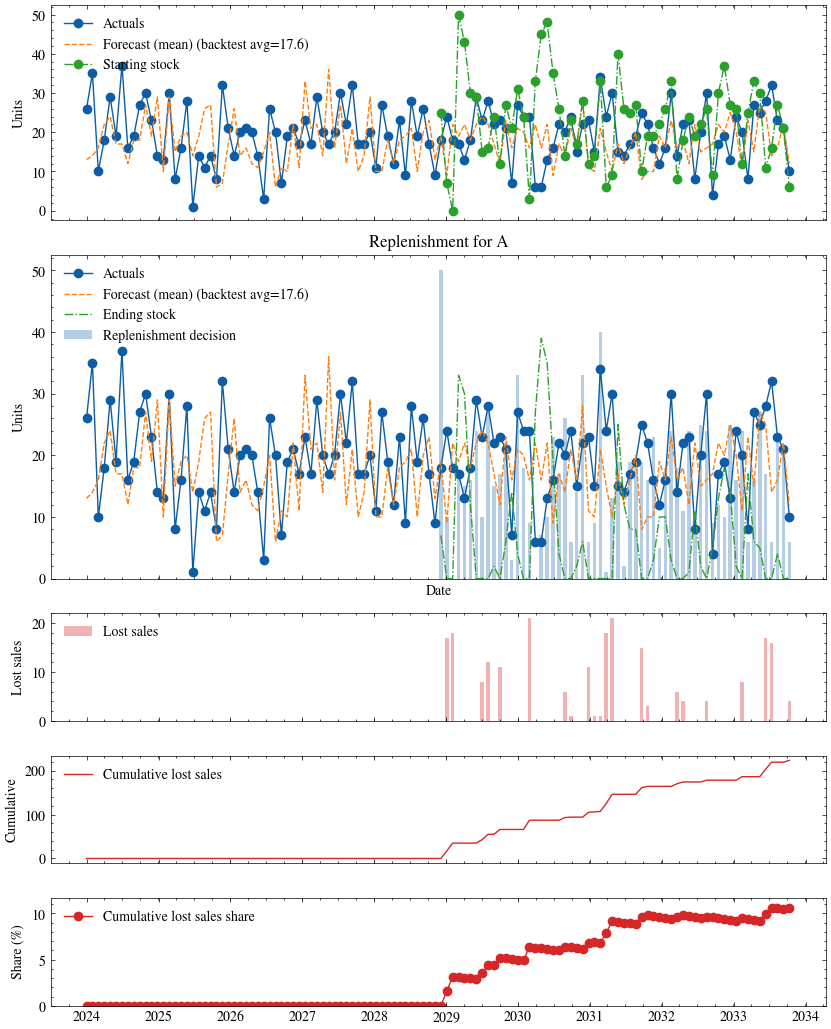

In [111]:
example_id = sigma_decisions_df["unique_id"].iloc[0]
plot_replenishment_decisions(rows_df, sigma_decisions_df, unique_id=example_id)


## 3) Optimize Sigma + Aggregation Window


In [112]:
candidate_windows

[3, 6, 9]

In [113]:
backtest_rmse = compute_backtest_rmse_by_article(backtest_rows)

point_configs = build_point_forecast_article_configs_from_standard_rows(
    backtest_rows,
    service_level_factor=.95,
    service_level_mode="service_level",
    fixed_rmse=backtest_rmse,
)

agg_sigma_result = optimize_aggregation_and_service_level_factors(
    point_configs,
    candidate_windows=candidate_windows,
    candidate_factors=candidate_service_levels,
    service_level_mode="service_level",
)
agg_best_factors = {
    unique_id: result.service_level_factor
    for unique_id, result in agg_sigma_result.items()
}
agg_windows = {
    unique_id: result.window
    for unique_id, result in agg_sigma_result.items()
}

agg_backtest_rmse = compute_backtest_rmse_by_article(
    backtest_rows,
    aggregation_window=agg_windows,
)

forecast_point_configs = build_point_forecast_article_configs_from_standard_rows(
    evaluation_rows,
    service_level_factor=agg_best_factors,
    service_level_mode="service_level",
    fixed_rmse=agg_backtest_rmse,
    actuals_override=backtest_actuals,
)
agg_simulations = {
    unique_id: simulate_replenishment_with_aggregation(
        periods=config.periods,
        demand=config.demand,
        initial_on_hand=config.initial_on_hand,
        lead_time=config.lead_time,
        policy=config.policy,
        aggregation_window=agg_windows[unique_id],
        holding_cost_per_unit=config.holding_cost_per_unit,
        stockout_cost_per_unit=config.stockout_cost_per_unit,
        order_cost_per_order=config.order_cost_per_order,
        order_cost_per_unit=config.order_cost_per_unit,
    )
    for unique_id, config in forecast_point_configs.items()
}
agg_decisions = build_replenishment_decisions_from_simulations(
    evaluation_rows,
    agg_simulations,
    aggregation_window=agg_windows,
    sigma=agg_best_factors,
    fixed_rmse=agg_backtest_rmse,
    service_level_mode="service_level",
)


In [114]:
agg_decisions_df = replenishment_decision_rows_to_dataframe(agg_decisions)
agg_decisions_df.head()


,unique_id,ds,quantity,demand,forecast_quantity,forecast_quantity_lead_time,reorder_point,order_up_to,incoming_stock,starting_stock,...,safety_stock,starting_on_hand,ending_on_hand,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,percentile_target
0,A,2028-12-05,74,18,16.666667,36.333333,21.871597,71.871597,0,25,...,-28.128403,25,7,7,74,0,0,0.22,3,None
1,A,2029-01-04,0,24,16.666667,37.333333,21.871597,71.871597,0,7,...,-28.128403,7,0,0,74,0,17,0.22,3,None
2,A,2029-02-03,0,18,21.000000,42.333333,34.871597,97.871597,0,0,...,-28.128403,0,0,0,74,0,18,0.22,3,None
3,A,2029-03-05,42,17,19.666667,42.333333,30.871597,89.871597,74,74,...,-28.128403,74,57,57,42,0,0,0.22,3,None
4,A,2029-04-04,0,13,20.666667,41.666667,33.871597,95.871597,0,57,...,-28.128403,57,44,44,42,0,0,0.22,3,None


0      0
1     17
2     18
3      0
4      0
5      0
6      0
7      0
8     12
9      0
10     0
11    13
12     0
13     0
14     8
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22    11
23    15
24     0
25     0
26     1
27     4
28    24
29    30
30     0
31     0
32     0
33     0
34    20
35    22
36     0
37     0
38     0
39     0
40     0
41    20
42     0
43     0
44     0
45     0
46     0
47     3
48     0
49     0
50     0
51     0
52     0
53     6
54     0
55     0
56    27
57     0
58     0
59     0
Name: missed_sales, dtype: int64


<Axes: title={'center': 'Replenishment for A'}, xlabel='Date', ylabel='Units'>

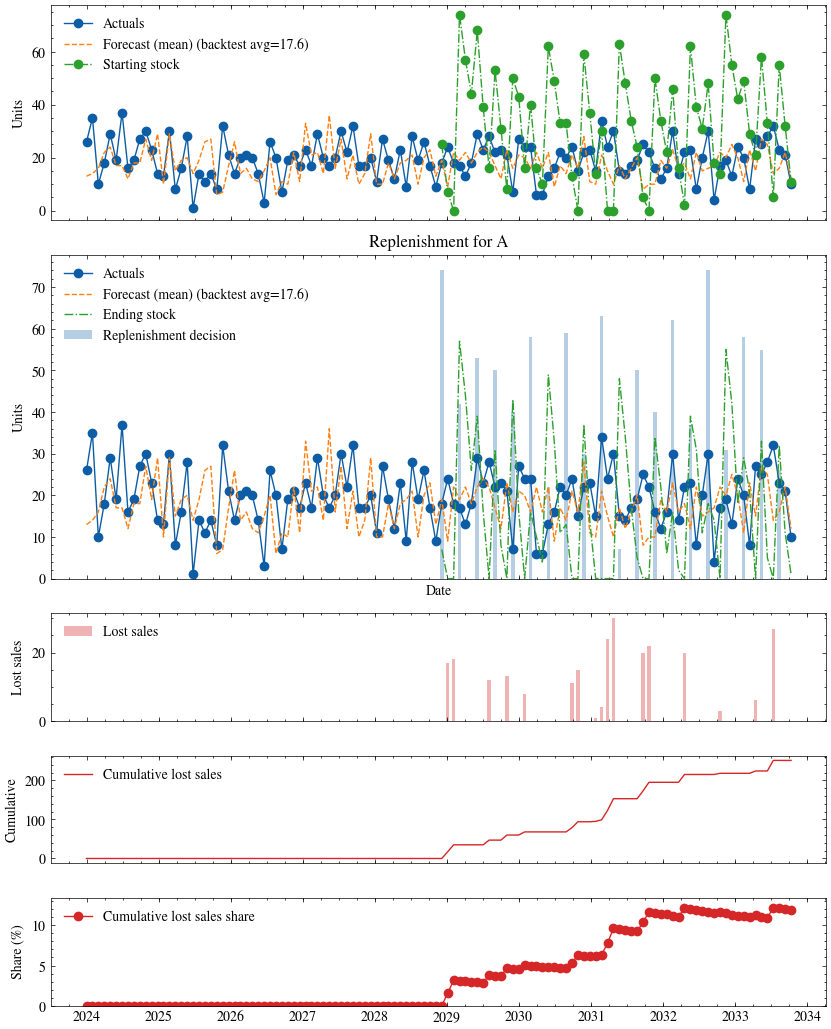

In [115]:
example_id = agg_decisions_df["unique_id"].iloc[0]
plot_replenishment_decisions(rows_df, agg_decisions_df, unique_id=example_id)


### Take a given service level and optimize aggregation windows

In [116]:
candidate_windows

[3, 6, 9]

In [117]:
backtest_rmse = compute_backtest_rmse_by_article(backtest_rows)

point_configs = build_point_forecast_article_configs_from_standard_rows(
    backtest_rows,
    service_level_factor=.99,
    service_level_mode="service_level",
    fixed_rmse=backtest_rmse,
)

agg_sigma_result = optimize_aggregation_and_service_level_factors(
    point_configs,
    candidate_windows=candidate_windows,
    candidate_factors=[.95],
    service_level_mode="service_level",
)
agg_best_factors = {
    unique_id: result.service_level_factor
    for unique_id, result in agg_sigma_result.items()
}
agg_windows = {
    unique_id: result.window
    for unique_id, result in agg_sigma_result.items()
}

agg_backtest_rmse = compute_backtest_rmse_by_article(
    backtest_rows,
    aggregation_window=agg_windows,
)

forecast_point_configs = build_point_forecast_article_configs_from_standard_rows(
    evaluation_rows,
    service_level_factor=agg_best_factors,
    service_level_mode="service_level",
    fixed_rmse=agg_backtest_rmse,
    actuals_override=backtest_actuals,
)
agg_simulations = {
    unique_id: simulate_replenishment_with_aggregation(
        periods=config.periods,
        demand=config.demand,
        initial_on_hand=config.initial_on_hand,
        lead_time=config.lead_time,
        policy=config.policy,
        aggregation_window=agg_windows[unique_id],
        holding_cost_per_unit=config.holding_cost_per_unit,
        stockout_cost_per_unit=config.stockout_cost_per_unit,
        order_cost_per_order=config.order_cost_per_order,
        order_cost_per_unit=config.order_cost_per_unit,
    )
    for unique_id, config in forecast_point_configs.items()
}
agg_decisions = build_replenishment_decisions_from_simulations(
    evaluation_rows,
    agg_simulations,
    aggregation_window=agg_windows,
    sigma=agg_best_factors,
    fixed_rmse=agg_backtest_rmse,
    service_level_mode="service_level",
)


0      0
1     17
2     18
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     0
30     0
31     0
32     0
33     0
34     0
35     0
36     0
37     0
38     0
39     0
40     0
41     0
42     0
43     0
44     0
45     0
46     0
47     0
48     0
49     0
50     0
51     0
52     0
53     0
54     0
55     0
56     0
57     0
58     0
59     0
Name: missed_sales, dtype: int64


,unique_id,ds,quantity,demand,forecast_quantity,forecast_quantity_lead_time,reorder_point,order_up_to,incoming_stock,starting_stock,...,safety_stock,starting_on_hand,ending_on_hand,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,percentile_target
0,A,2028-12-05,162,18,16.666667,36.333333,109.916489,159.916489,0,25,...,59.916489,25,7,7,162,0,0,0.95,3,None
1,A,2029-01-04,0,24,16.666667,37.333333,109.916489,159.916489,0,7,...,59.916489,7,0,0,162,0,17,0.95,3,None
2,A,2029-02-03,0,18,21.000000,42.333333,122.916489,185.916489,0,0,...,59.916489,0,0,0,162,0,18,0.95,3,None
3,A,2029-03-05,42,17,19.666667,42.333333,118.916489,177.916489,162,162,...,59.916489,162,145,145,42,0,0,0.95,3,None
4,A,2029-04-04,0,13,20.666667,41.666667,121.916489,183.916489,0,145,...,59.916489,145,132,132,42,0,0,0.95,3,None


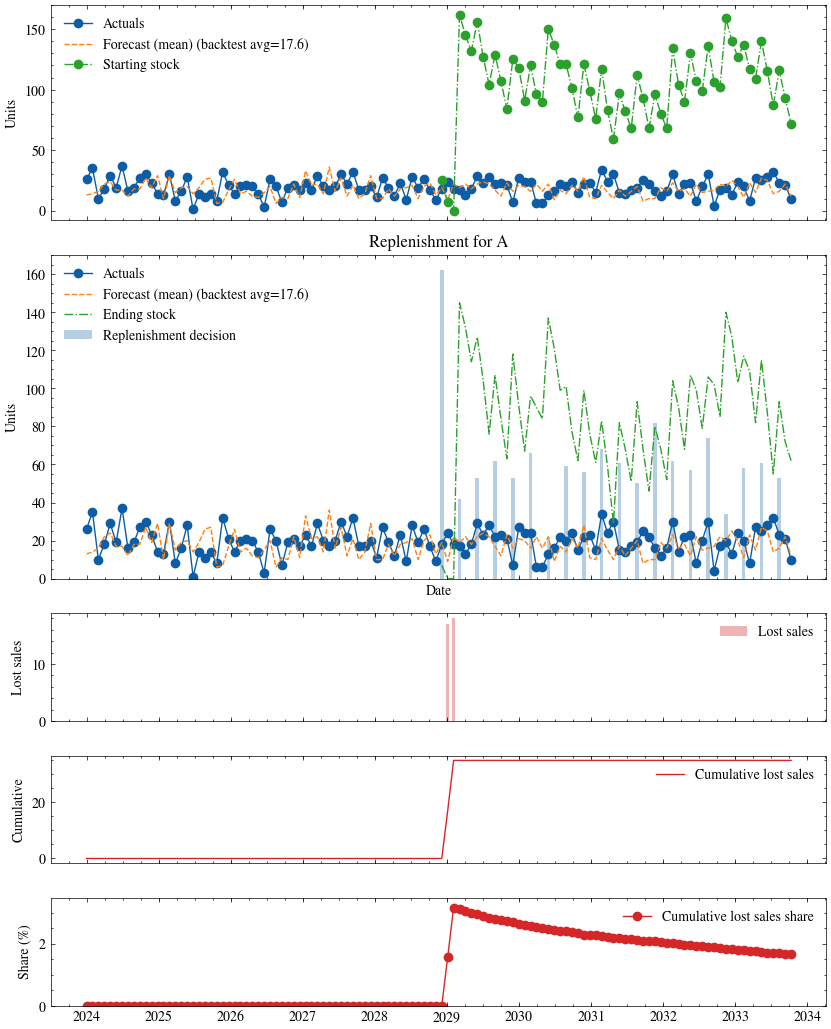

In [118]:
agg_decisions_df = replenishment_decision_rows_to_dataframe(agg_decisions)

example_id = agg_decisions_df["unique_id"].iloc[0]
plot_replenishment_decisions(rows_df, agg_decisions_df, unique_id=example_id)

agg_decisions_df.head()

In [119]:
agg_decisions_df[agg_decisions_df.ds > '2026-06-19']['missed_sales'].sum()

np.int64(7179)

In [120]:
agg_decisions_df[agg_decisions_df.ds > '2026-06-19']['demand'].sum()

np.int64(240519)

In [121]:
77 / 116312

0.0006620125180548869